# 3 - Mapas

Vamos também gerar alguns mapas como parte de nossa análise de dados. Afinal, temos 96 gráficos, e precisamos extrair as principais informações dos dados. Os mapas que faremos serão:

- Atendimento (matrícula) absoluto por tempo.
- Atendimento (matrícula) relativo (relação à população) por tempo.
- Fila (demanda) absoluto por tempo.
- Fila (demanda) relativo por tempo.
- Variação entre junho de 2016 e dezembro de 2017 do atendimento absoluto.
- Variação entre junho de 2016 e dezembro de 2017 do atendimento relativo.

Para facilitar, temos uma função que nos gera os mapas.

In [6]:
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
from matplotlib.pyplot import figure
from pylab import rcParams

rcParams['figure.figsize'] = 9, 12
figure(num=None, dpi=400, facecolor='w', edgecolor='k')

def geraMapa(periodo, tema, atributo, r_i, g_i, b_i, r_f, g_f, b_f, normatizador=1):
    dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == periodo]
    recorte = dados.sort_values(by=atributo, ascending=False)
    recorte = recorte[['DISTRITO', atributo]]

    sf = shp.Reader('dados/LAYER_DISTRITO/DEINFO_DISTRITO.shp')

    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')

    for shapeRec in sf.iterShapeRecords():
        shape = shapeRec.shape
        rec = shapeRec.record

        nome = rec[3].split(' ')
        if 'JD' in nome:
            nome[0] = 'JARDIM'
        if 'CID' in nome:
            nome[0] = 'CIDADE'
        rec[3] = ' '.join(nome)

        dado = recorte[recorte['DISTRITO'] == rec[3]]
        interesse = float(dado[atributo].values)/normatizador
        interesse = interesse if interesse < 1 else 1 

        R = r_i/255.0 - (r_i-r_f)/255.0*interesse
        G = g_i/255.0 - (g_i-g_f)/255.0*interesse
        B = b_i/255.0 - (b_i-b_f)/255.0*interesse

        polygon = Polygon(shape.points)
        patch = PolygonPatch(polygon, facecolor=[R,G,B], edgecolor=[0,0,0], alpha=1.0, zorder=2)
        ax.add_patch(patch)

    ax.text(0.5, 0.98, tema + ' em ' + periodo,
            horizontalalignment='center', fontsize=14,
            transform=ax.transAxes)

    plt.ylim(7340000,7420000)
    plt.xlim(310000,365000)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.show()

(311073.346766, 363024.6579139999, 7340167.93605, 7419822.71895)

<Figure size 2400x3200 with 0 Axes>

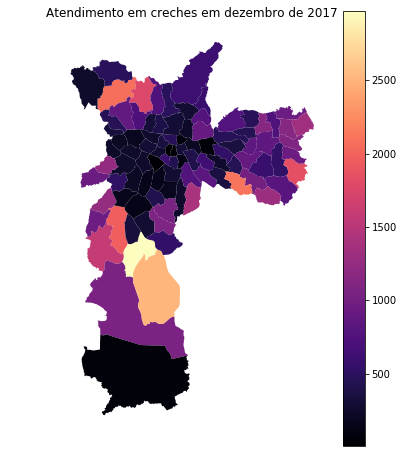

In [24]:
import geopandas as gpd

rcParams['figure.figsize'] = 6, 8
figure(num=None, dpi=400, facecolor='w', edgecolor='k')

dados_educ_pop = pd.read_csv('dados/dados_educ_pop.csv', sep = ',')
distritos = gpd.read_file('dados/LAYER_DISTRITO/DEINFO_DISTRITO.shp')

dados = dados_educ_pop[dados_educ_pop['MES_ANO_REF'] == 'dez-06']
dados = dados[['DISTRITO', 'MAT_CRECHE']]

for i in distritos.index:
    nome = distritos.at[i, 'NOME_DIST'].split(' ')
    if 'JD' in nome:
        nome[0] = 'JARDIM'
    if 'CID' in nome:
        nome[0] = 'CIDADE'
    distritos.at[i, 'NOME_DIST'] = ' '.join(nome)
    recorte = dados[dados['DISTRITO'] == distritos.at[i, 'NOME_DIST']]
    distritos.at[i, 'MAT_CRECHE'] = recorte['MAT_CRECHE'].values
    
ax = distritos.plot(column='MAT_CRECHE', cmap='magma', legend=True)
ax.set_title("Atendimento em creches em dezembro de 2017")
ax.axis('off')

## Mapas do atendimento absoluto por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). O gradiente utilizado vai de branco a verde-escuro.

In [60]:
dados_educ_pop = pd.read_csv('dados/dados_educ_pop.csv', sep = ',')

#for periodo in dados_educ_pop.MES_ANO_REF.unique():
#     geraMapa(periodo=periodo, tema='Atendimento absoluto', atributo='MAT_CRECHE', r_i=247, g_i=252, b_i=245, r_f=0, g_f=68, b_f=27, normatizador=12486)

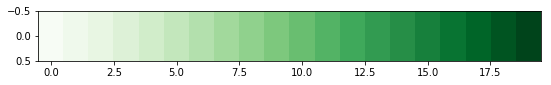

In [59]:
m = np.zeros((1,20))
for i in range(20):
    m[0,i] = (i*5)/100.0
plt.imshow(m, cmap='Greens', aspect=2)

## Mapa do atendimento relativo por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). O gradiente utilizado vai de branco a verde-escuro.

In [62]:
dados_educ_pop['ATEND_REL'] = dados_educ_pop['MAT_CRECHE'] / dados_educ_pop['TOTAL']

#for periodo in dados_educ_pop.MES_ANO_REF.unique():
#     geraMapa(periodo=periodo, tema='Atendimento relativo', atributo='ATEND_REL', r_i=247, g_i=252, b_i=245, r_f=0, g_f=68, b_f=27)

## Mapa da fila absoluta por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). O gradiente utilizado vai de branco a vermelho.

In [63]:
#for periodo in dados_educ_pop.MES_ANO_REF.unique():
#     geraMapa(periodo=periodo, tema='Demanda por vagas de creches', atributo='DEM_CRECHE', r_i=255, g_i=255, b_i=255, r_f=255, g_f=0, b_f=0, normatizador=9171)

## Mapa da fila relativa por tempo

Para esses mapas, será gerado um imagem para cada período de referência (trimestre). O gradiente utilizado vai de branco a vermelho.

In [64]:
dados_educ_pop['FILA_REL'] = dados_educ_pop['DEM_CRECHE'] / dados_educ_pop['TOTAL']

#for periodo in dados_educ_pop.MES_ANO_REF.unique():
#    geraMapa(periodo=periodo, tema='Demanda por vagas de creches', atributo='FILA_REL', r_i=255, g_i=255, b_i=255, r_f=255, g_f=0, b_f=0, )

## Lista da evolução do número de matrículas

Essa lista trará a variação, do número de matrículas, de junho de 2006 a dezembro de 2017. A última coluna trará a variação percentual desses valores.

In [52]:
dados_matricula = dados_educ_pop[['DISTRITO', 'MAT_CRECHE', 'MES_ANO_REF']]
dados_jun_2006 = dados_matricula[dados_matricula['MES_ANO_REF'] == 'jun-06']
dados_jun_2006.columns = ['DISTRITO', 'MAT_JUN_06', 'MES_ANO_REF']
dados_dez_2017 = dados_matricula[dados_matricula['MES_ANO_REF'] == 'dez-17']
dados_dez_2017.columns = ['DISTRITO', 'MAT_DEZ_17', 'MES_ANO_REF']

dados_matricula = dados_jun_2006.merge(dados_dez_2017, on = ['DISTRITO'])
dados_matricula = dados_matricula[['DISTRITO', 'MAT_JUN_06', 'MAT_DEZ_17']]

dados_matricula['EV_ABS_NUM'] = dados_matricula['MAT_DEZ_17'] - dados_matricula['MAT_JUN_06']
dados_matricula['EV_ABS_PC'] = dados_matricula['MAT_DEZ_17'] / dados_matricula['MAT_JUN_06']
dados_matricula.sort_values(by='EV_ABS_NUM', ascending=False)
geraMapas(tema='Demanda por vagas de creches', atributo='FILA_REL', r_i=255, g_i=255, b_i=255, r_f=255, g_f=0, b_f=0, )
# dados_matricula.sort_values(by='EV_ABS_PC', ascending=False)

,DISTRITO,MAT_JUN_06,MAT_DEZ_17,EV_ABS_NUM,EV_ABS_PC
29,GRAJAU,2555.0,12486.0,9931.0,4.886888
24,CIDADE TIRADENTES,1676.0,11423.0,9747.0,6.815632
10,BRASILANDIA,2121.0,11488.0,9367.0,5.416313
34,ITAIM PAULISTA,1284.0,9897.0,8613.0,7.707944
46,LAJEADO,947.0,9361.0,8414.0,9.884900
41,JARDIM ANGELA,1683.0,9408.0,7725.0,5.590018
18,CAPAO REDONDO,902.0,8456.0,7554.0,9.374723
44,JARDIM SAO LUIS,1847.0,9257.0,7410.0,5.011911
35,ITAQUERA,843.0,7211.0,6368.0,8.553974
40,JARAGUA,2008.0,7870.0,5862.0,3.919323


## Lista da evolução da demanda

Essa lista trará a variação, em número de crianças, de junho de 2006 a dezembro de 2017. A última coluna trará a variação percentual desses valores.

In [36]:
dados_demanda = dados_educ_pop[['DISTRITO', 'DEM_CRECHE', 'MES_ANO_REF']]
dados_jun_2006 = dados_demanda[dados_demanda['MES_ANO_REF'] == 'jun-06']
dados_jun_2006.columns = ['DISTRITO', 'DEM_JUN_06', 'MES_ANO_REF']
dados_dez_2017 = dados_demanda[dados_demanda['MES_ANO_REF'] == 'dez-17']
dados_dez_2017.columns = ['DISTRITO', 'DEM_DEZ_17', 'MES_ANO_REF']

dados_demanda = dados_jun_2006.merge(dados_dez_2017, on = ['DISTRITO'])
dados_demanda = dados_demanda[['DISTRITO', 'DEM_JUN_06', 'DEM_DEZ_17']]

dados_demanda['EV_ABS_NUM'] = dados_demanda['DEM_DEZ_17'] - dados_demanda['DEM_JUN_06']
dados_demanda['EV_ABS_PC'] = dados_demanda['DEM_DEZ_17'] / dados_demanda['DEM_JUN_06']
# dados_demanda.sort_values(by='EV_ABS_NUM', ascending=True)
# dados_demanda.sort_values(by='EV_ABS_PC', ascending=True)